In [6]:
# CÉLULA DE DIAGNÓSTICO - Execute esta célula primeiro se tiver problemas de importação
# Se esta célula falhar, REINICIE O KERNEL (Kernel -> Restart Kernel)

print("Testando importações...")
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} OK")
except Exception as e:
    print(f"✗ Erro ao importar PyTorch: {e}")
    print("→ SOLUÇÃO: Reinicie o kernel do Jupyter")

try:
    from sentence_transformers import SentenceTransformer
    print("✓ sentence_transformers OK")
except Exception as e:
    print(f"✗ Erro ao importar sentence_transformers: {e}")
    print("→ Tentando transformers...")
    try:
        from transformers import AutoTokenizer, AutoModel
        print("✓ transformers OK")
    except Exception as e2:
        print(f"✗ Erro ao importar transformers: {e2}")

print("\nDiagnóstico concluído. Se houver erros, reinicie o kernel.")


Testando importações...
✓ PyTorch 2.6.0+cu124 OK
✓ sentence_transformers OK

Diagnóstico concluído. Se houver erros, reinicie o kernel.


In [7]:
import os
import pickle
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Carregar apenas as colunas necessárias para economizar memória
print("Carregando dados...")
base_path = 'database_50k'
df_authorships = pd.read_csv(f'{base_path}/authorships.csv', usecols=['work_id', 'author_id'])
df_works = pd.read_csv(f'{base_path}/works.csv', usecols=['id', 'abstract']).dropna()

# 2. Cruzar Autores com os Resumos de seus trabalhos
df_author_works = df_authorships.merge(df_works, left_on='work_id', right_on='id')

# 3. Agrupar os resumos por autor. 
# Dica: Para não estourar a memória do modelo de linguagem, 
# vamos concatenar no máximo os 5 últimos/principais abstracts de cada autor.
print("Construindo corpus dos autores...")
author_corpus = df_author_works.groupby('author_id')['abstract'].apply(
    lambda x: ' '.join(x.astype(str).head(5))
).reset_index()

# 4. Gerar os Embeddings (Vetores Semânticos) com SciBERT
cache_path = 'scibert_author_embeddings.pkl'
model_name = 'allenai/scibert_scivocab_uncased'

# Função para carregar embeddings do cache
def load_embeddings():
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

# Função para salvar embeddings no cache
def save_embeddings(data):
    with open(cache_path, 'wb') as f:
        pickle.dump(data, f)

# Tentar carregar do cache
author_embeddings_dict = load_embeddings()

if author_embeddings_dict is None:
    print("Gerando embeddings com SciBERT (isso pode levar alguns minutos)...")
    # SentenceTransformer detecta automaticamente GPU/CPU
    encoder = SentenceTransformer(model_name)
    
    embeddings = encoder.encode(
        author_corpus['abstract'].tolist(),
        batch_size=32,
        show_progress_bar=True
    )
    
    # Criar um dicionário para busca rápida: {author_id: vetor_numpy}
    author_embeddings_dict = dict(zip(author_corpus['author_id'], embeddings))
    
    # Salvar no cache
    save_embeddings(author_embeddings_dict)
    print(f"Embeddings salvos em {cache_path}")
else:
    print(f"Embeddings carregados do cache ({cache_path})")

Carregando dados...
Construindo corpus dos autores...
Embeddings carregados do cache (scibert_author_embeddings.pkl)


In [8]:
# Carregar métricas de impacto do autor
df_authors_meta = pd.read_csv(f'{base_path}/unique_authors_metadata.csv', 
                              usecols=['id', 'works_count', 'h_index', 'cited_by_count'])

# Dicionários para busca rápida em tempo O(1)
h_index_dict = dict(zip(df_authors_meta['id'], df_authors_meta['h_index']))
works_count_dict = dict(zip(df_authors_meta['id'], df_authors_meta['works_count']))

In [9]:
def extract_pair_features(author_A, author_B, topo_model):
    """
    Função que recebe dois IDs de autores e retorna um dicionário com todas as features.
    Assumimos que você já tem o `topo_model` com o grafo carregado.
    """
    features = {}
    
    # --- FEATURES DE TOPOLOGIA (do seu código original) ---
    features['amigos_em_comum'] = topo_model.get_common_neighbors_count(author_A, author_B)
    features['jaccard_index'] = topo_model.get_jaccard_coefficient(author_A, author_B)
    features['adamic_adar'] = topo_model.get_adamic_adar(author_A, author_B)
    
    # --- FEATURES DE CONTEÚDO / SEMÂNTICA ---
    emb_A = author_embeddings_dict.get(author_A)
    emb_B = author_embeddings_dict.get(author_B)
    
    if emb_A is not None and emb_B is not None:
        # cosine_similarity espera arrays 2D, por isso o reshape
        sim = cosine_similarity(emb_A.reshape(1, -1), emb_B.reshape(1, -1))[0][0]
        features['similiaridade_cosseno'] = sim
    else:
        features['similiaridade_cosseno'] = 0.0 # Caso um dos autores não tenha abstract
        
    # --- FEATURES DE POPULARIDADE / AUTORIDADE ---
    # Pegamos o H-index. Se for NaN, assumimos 0
    features['h_index_A'] = h_index_dict.get(author_A, 0)
    features['h_index_B'] = h_index_dict.get(author_B, 0)
    
    # Podemos criar uma feature que é a diferença de senioridade entre eles
    features['diff_h_index'] = abs(features['h_index_A'] - features['h_index_B'])
    
    return features

# Exemplo de como você montaria o DataFrame final:
# dataset_rows = []
# para cada (autor_A, autor_B, target) na sua lista de treino:
#     linha = extract_pair_features(autor_A, autor_B, topo_model)
#     linha['colaborou_no_futuro'] = target
#     dataset_rows.append(linha)
#
# df_final = pd.DataFrame(dataset_rows)

In [11]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import itertools
from abc import ABC, abstractmethod
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer 


In [12]:
class BaseRecommender(ABC):
    def __init__(self, name):
        self.name = name
        self.train_df = None
        
    @abstractmethod
    def fit(self, train_df):
        """Treina o modelo com os dados de treino."""
        pass
    
    @abstractmethod
    def recommend(self, author_id, top_n=10):
        """Retorna uma lista de author_ids recomendados."""
        pass

In [13]:
class TopologyRecommender(BaseRecommender):
    def __init__(self):
        super().__init__("Topology (Graph Coauthor)")
        self.graph = defaultdict(set)
        self.popular_authors = []
        
    def fit(self, train_df):
        self.train_df = train_df
        print(f"[{self.name}] Construindo grafo...")
        
        # Construção do Grafo
        for _, group in train_df.groupby('work_id'):
            authors = group['author_id'].tolist()
            if len(authors) > 1:
                for u, v in itertools.permutations(authors, 2):
                    self.graph[u].add(v)
        
        # Cálculo de Popularidade (para fallback)
        popularity_counter = Counter()
        for author, neighbors in self.graph.items():
            popularity_counter[author] = len(neighbors)
        self.popular_authors = [auth for auth, _ in popularity_counter.most_common()]
        print(f"[{self.name}] Grafo construído com {len(self.graph)} autores.")

    def recommend(self, author_id, top_n=10):
        recommendations = []
        current_coauthors = self.graph.get(author_id, set())
        
        # Lógica de Amigos em Comum (2 hops)
        if author_id in self.graph:
            candidates = []
            for neighbor in current_coauthors:
                neighbors_of_neighbor = self.graph.get(neighbor, set())
                for candidate in neighbors_of_neighbor:
                    if candidate != author_id and candidate not in current_coauthors:
                        candidates.append(candidate)
            
            recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
        
        # Fallback: Populares
        if len(recommendations) < top_n:
            for pop in self.popular_authors:
                if pop != author_id and pop not in recommendations and pop not in current_coauthors:
                    recommendations.append(pop)
                    if len(recommendations) >= top_n:
                        break
                        
        return recommendations[:top_n]


In [14]:
import math

# Adicionando os métodos matemáticos à classe TopologyRecommender
def get_common_neighbors_count(self, u, v):
    return len(self.graph.get(u, set()) & self.graph.get(v, set()))

def get_jaccard_coefficient(self, u, v):
    neighbors_u = self.graph.get(u, set())
    neighbors_v = self.graph.get(v, set())
    intersection = len(neighbors_u & neighbors_v)
    union = len(neighbors_u | neighbors_v)
    return intersection / union if union > 0 else 0.0

def get_adamic_adar(self, u, v):
    common_neighbors = self.graph.get(u, set()) & self.graph.get(v, set())
    score = 0.0
    for w in common_neighbors:
        degree = len(self.graph.get(w, set()))
        if degree > 1:
            score += 1.0 / math.log(degree)
    return score

# Injetando na classe existente dinamicamente
TopologyRecommender.get_common_neighbors_count = get_common_neighbors_count
TopologyRecommender.get_jaccard_coefficient = get_jaccard_coefficient
TopologyRecommender.get_adamic_adar = get_adamic_adar

# Obs: Assumindo que a variável `topo_model` já foi instanciada e treinada (fit) em células anteriores

In [16]:
authors_df = pd.read_csv('database/authorships.csv')
works_df = pd.read_csv('database/works.csv')

merged_df = authors_df.merge(
    works_df[['id', 'publication_date', 'title', 'abstract', 'language']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id', 'title', 'abstract', 'language']).drop(columns=['id'])
merged_df = merged_df[merged_df['language'] == 'en']

unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
test_graph_raw = build_graph(test_df)

test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele já conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links

In [19]:
topo_model = TopologyRecommender()

In [21]:
import random
from tqdm.notebook import tqdm # Para vermos a barra de progresso

print("1. Gerando Pares Positivos...")
pares_positivos = []
for autor, colaboradores_futuros in test_ground_truth.items():
    for colab in colaboradores_futuros:
        pares_positivos.append((autor, colab, 1))

print(f"Total de colaborações reais (positivos): {len(pares_positivos)}")

print("2. Gerando Pares Negativos (balanceamento)...")
pares_negativos = []
# Pegamos todos os autores que existem no grafo de treino
todos_autores = list(train_graph.keys()) 

# Sorteamos pares até ter a mesma quantidade de positivos
while len(pares_negativos) < len(pares_positivos):
    autor_A = random.choice(todos_autores)
    autor_B = random.choice(todos_autores)
    
    if autor_A == autor_B:
        continue
        
    # Garante que eles nunca colaboraram antes (treino) e nem no futuro (teste)
    ja_colaboraram_no_treino = autor_B in train_graph.get(autor_A, set())
    colaboraram_no_teste = autor_B in test_ground_truth.get(autor_A, set())
    
    if not ja_colaboraram_no_treino and not colaboraram_no_teste:
        pares_negativos.append((autor_A, autor_B, 0))

todos_os_pares = pares_positivos + pares_negativos
random.shuffle(todos_os_pares) # Embaralha para o modelo não ficar viciado

print(f"Total de pares no dataset de análise: {len(todos_os_pares)}")

# Extraindo as features para cada par
print("3. Extraindo as características (isso pode levar um tempinho)...")
dataset_rows = []
for autor_A, autor_B, target in tqdm(todos_os_pares):
    features = extract_pair_features(autor_A, autor_B, topo_model)
    features['colaborou_no_futuro'] = target
    dataset_rows.append(features)

df_final = pd.DataFrame(dataset_rows)
# Preenchemos com 0 caso alguma feature falhe ou retorne NaN
df_final = df_final.fillna(0) 

display(df_final.head())

1. Gerando Pares Positivos...
Total de colaborações reais (positivos): 36720
2. Gerando Pares Negativos (balanceamento)...
Total de pares no dataset de análise: 73440
3. Extraindo as características (isso pode levar um tempinho)...


  0%|          | 0/73440 [00:00<?, ?it/s]

,amigos_em_comum,jaccard_index,adamic_adar,similiaridade_cosseno,h_index_A,h_index_B,diff_h_index,colaborou_no_futuro
0,0,0.0,0.0,0.0,0,0,0,0
1,0,0.0,0.0,0.0,0,0,0,1
2,0,0.0,0.0,0.0,0,0,0,0
3,0,0.0,0.0,0.0,0,0,0,0
4,0,0.0,0.0,0.0,0,0,0,0


Treinando o Random Forest para análise de importância...


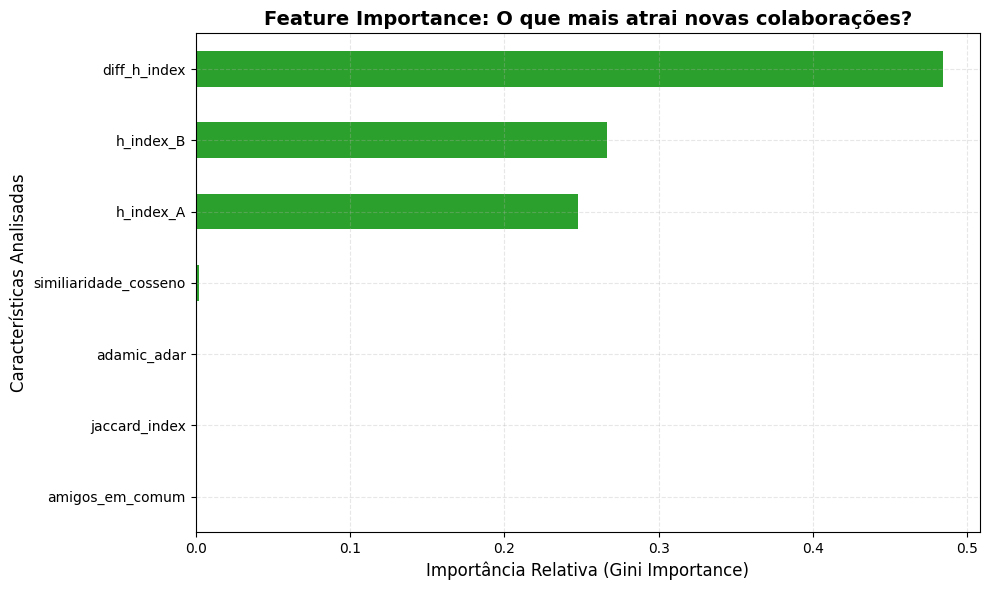

Acurácia do modelo detetive na separação de pares: 51.98%


In [22]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

print("Treinando o Random Forest para análise de importância...")

# Separar os dados: X (Características) e y (Resposta certa)
X = df_final.drop(columns=['colaborou_no_futuro'])
y = df_final['colaborou_no_futuro']

# Instanciar e treinar o modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X, y)

# Extrair as importâncias das features
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=True)

# Plotar o gráfico bonito
plt.figure(figsize=(10, 6))
importances.plot.barh(color='#2ca02c') # Cor verde combinando com a paleta do seu notebook
plt.title("Feature Importance: O que mais atrai novas colaborações?", fontsize=14, fontweight='bold')
plt.xlabel("Importância Relativa (Gini Importance)", fontsize=12)
plt.ylabel("Características Analisadas", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Opcional: Mostrar também a acurácia básica do modelo para ver se ele conseguiu aprender bem
acuracia = clf.score(X, y)
print(f"Acurácia do modelo detetive na separação de pares: {acuracia:.2%}")